## SED Fitting with Prospector

A brief intro to SED modeling and using prospector. I cover two things in this tutorial: (1) basics of SED modeling that apply to any SED fitting code and (2) Bayesian inference (to the best of my ability). 

Before getting started, we need to install a few packages to run Prospector:

1. sedpy : this manages the details of our observations and allows us to interface with the properties of the photometric filters used. You can find sedpy here: https://github.com/bd-j/sedpy
2. dynesty : this is the backbone of propsector that handles the actual fitting methods. It is a form of Bayesian modeling similar to MCMC codes like 'emcee' but a bit more sophisticated. You can find dynesty here: https://github.com/joshspeagle/dynesty
3. fsps : this handles the stellar modeling for prospector. by itself, it's a super useful tool for generating stellar spectra. The core of fsps is a Fortran code but these days, the python bindings for fsps now come with its own fsps source code, meaning we no longer have to compile the Fortran code first then install the python wrapper. All we need is to clone the fortran fsps

                export SPS_HOME="/path/where/you/want/to/download/fsps"
                git clone https://github.com/cconroy20/fsps.git $SPS_HOME
                
And then pip install python-fsps

                python -m pip install fsps
                
4. Prospector : prospector is the tool that combines the above packages to model the SEDs of galaxies. You can find it here: https://github.com/bd-j/prospector 
It also has a pretty decent demo on how to use prospector: https://github.com/bd-j/prospector/blob/main/demo/InteractiveDemo.ipynb

For visualization purposes, we'll also want to install 2 packages: corner, which helps us plot corner plots (https://github.com/dfm/corner.py) and arviz, which allows us to do 'advanced' things with corner (conda install arviz) 


## step 1: what is SED fitting

SED modeling basically entails mapping the observed light of a galaxy at different wavelengths to their physical properties like stellar mass, star formation rate, and dust mass. There's a bunch of different codes that do this with varying levels of sophistication: FAST, CIGALE, MAGPHYS, ProSpect, Prospector, BAGPIPES, and many, many more. 

To model a galaxy spectrum and infer the galaxy's properties, there's a bunch of assumptions we have to make about how and when the stars formed in a galaxy (the star formation history), how much and what kind of dust is in that galaxy (dust attenuation and emisision), the properties of regions like HII nebulae and AGN. The figure below, pulled from Charlie Conroy's great review article on SED fitting, sums up the various components in SED modeling. For the purposes of this tutorial, we're going to focus on just the components pertaining to stars and dust. 

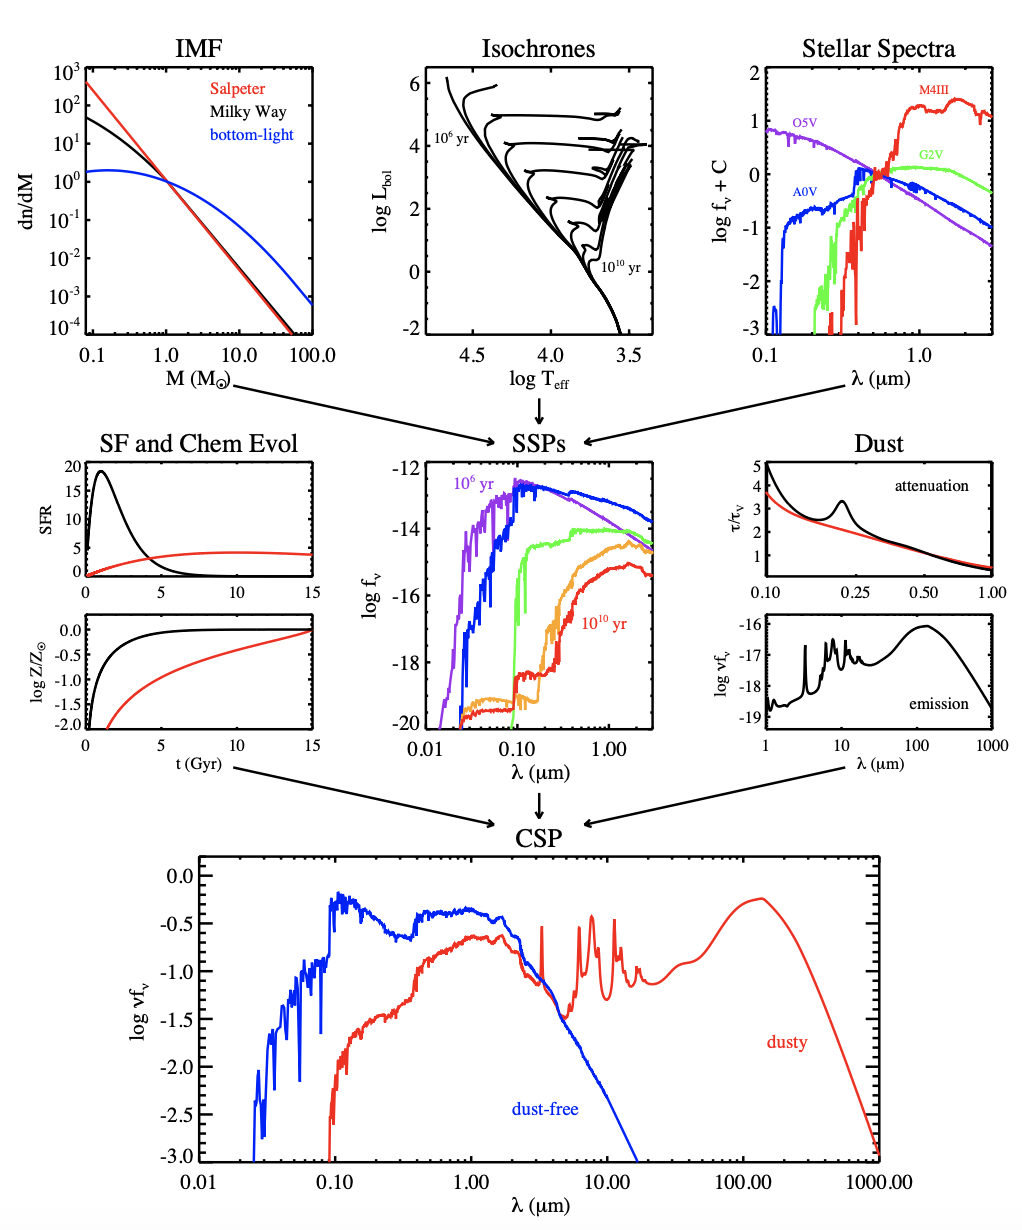



The top row concerns modeling stellar evolution. The IMF represents the stellar mass distribution of stars in a galaxy, literally how many stars of each mass are born in a galaxy -- there's a lot of debate over what the IMF is in various regions of our own Galaxy is but for our purposes, we just assume one of the typical distributions from the literature like Kroupa 2002 or Chabrier 2003. The isochrones are models detailing how stars move about the HR diagram as a function of time. Each line in that plot represents the distribution of stars for a fixed time. Stars that are born at the same time, but of different masses, will occupy different regions in color-magnitude space, impacting the colors of a galaxy. The right-hand plot shows spectra for a few different spectral types. Combine these three ingredients and we get something called a simple stellar population, or SSP, shown in the middle panel of the middle row. A simple stellar population represents the spectrum of a group of stars that are the same age. Think of it as taking a picture of a globular cluster: those stars formed at ~the same time but are of different masses and so the combined spectrum of that cluster will depend on how many high/low mass (hot/cold temp) stars there are and the age of that cluster. 

But a galaxy is definitely not just a globular cluster. It's more of a bunch of globular clusters of different ages put together. So how do we describe that spectrum? We combine it with a model for the star formation history of the galaxy -- literally, when did those globular clusters form? The left panel in the middle row shows two examples of a star formation history model (let's ignore the bottom plot showing metallicity). SFHs of real galaxies are diverse from galaxy-to-galaxy and have different short- and long-term variability. Convolving a model for SFH with an SSP gives us a compsite stellar spectrum combining the effects of stellar spectral types and stellar age. We can see an example of this spectrum in the blue curve plotted in the bottom row. 

Finally, to the shagrin of most UV and optical astronomers, a galaxy is not just stars, it also contains dust. Dust modulates the spectrum of a galaxy by absorbing the UV and optical light of stars and re-emitting that light as a blackbody in the far-infrared. This absorption (+ scattering) is called dust attenuation and is modeled with a dust attenuation curve. In the right panel of the middle row, we see an example of this where tau (optical depth) is plotted as a function of wavelength. Dust preferentially absorbs light (i.e., higher optical depths) in the UV and not as much in the red / near-IR. There's several features to a dust attenuation curve but for now, we'll stick with using one of the most commonly used attenuation curves in the literature: the Calzetti 2001 curve, which is shown in red in the plot. The plot right underneath shows the resulting dust emission spectra. Focusing on the peak of the curve around 100 micron, this spectrum is the result of the dust absorbing light in the UV, heating up, and re-emitting that light as a thermal blackbody. The weird features around 10 micron are the result of a special kind of dust called PAHs (polycyclic aromatic hydrocarbon) -- these are fascinating but we'll ignore them for now. The shape of the blackbody curve is dependent on the amount of dust and the dust temperature. 

Combining the two rows, we get a 'composite' galaxy spectra, including the contributions of stars of all ages and dust, shown in red in the bottom plot. This is the general shape of a galaxy SED: the stars dominate in the UV and optical while the dust emission dominates in the mid- to far-infrared. To extract information from a galaxy SED, we essentially do the above process backwards: what star and dust spectra are the best fit to the observed SED, from which we can derive the properties of the galaxy? To figure that out, we select models for the stellar evolution, star formation history, and dust. The stellar evolution models are typically fixed (i.e., we choose one model set and stick with it), but the parameters of the star formation history model and the dust attenuation/emission models can vary -- this represents the basis of our MCMC problem: what combination of model parameters give us a best fit to our data? To perform this fit, we'll use fsps+dynesty+prospector.

## step 2: how to fit data

The basic idea anytime we want to fit a model to data is to literally minimize the difference between the model and the data. In its most basic form, this means generating a model SED and calculating the chi square statistic, with the 'best fit' model having the lowest chi square. In a more sophisticated form, this involves Bayesian inference. I'm never going to do an explanaition of Bayesian statistics justice, so if you're super interested in learning the mechanics of this, I suggest doing outside readins. Regardless, the basis of Bayesian inference is that we have some 'prior' knowledge that we can use to construct the probability distribution of model parameters, which can in turn be used to construct a sort-of best fit model SED. Bayesian inference comes from Bayes theorem (which I'll point to the wiki page for more info: https://en.wikipedia.org/wiki/Bayes%27_theorem) which says the probability distribution of a model parameter (called the posterior distribution) is related to the likelihood of that model parameter * the prior distribution of that model parameter. If you've ever read a paper about model fitting or listened to a colloquium about deriving properties of something from a model, this is where 'prior,' 'posterior,' and 'likelihood' come from. 

What this means in practice is that for any set of models we choose for our SED components (star formation history, dust), the model SED is evaluated based on the prior knowledge of the distribution of model parameters and the likelihood of that model parameter representing the true data. For our purposes, the likelihood function is taken care of in the internals of prospector/dynesty. Thus for each (variable) model parameter, we will choose a prior distribution based on our knowledge of that parameter. Literally, what are the physical or known values this model parameter can take? An example is the age of a galaxy: we know that a galaxy has to have an age greater than zero and less than the age of the universe. Now, priors can have any degree of complexity but most of the time we will use an 'uninformative' prior, i.e., a prior that does not impose a lot of weight on the posterior distribution of the model paramter. An example of an uninformative prior is a uniform distribution, and for the age of the galaxy, the prior would range from 0 to 14 Gyr with every value in between having equal probability within the prior space. An example of an 'informative' prior would be a Gaussian, where galaxy ages around the mean of the Gaussian would have greater weight than ages close to the wings. Neither prior distribution is necessarily 'wrong,' (and believe me, there's tons of discussion on the intricacies of choosing priors) and generally is entirely dependent on the information/data we have and the problem we are trying to solve. 

Specifically for prospector, which we'll see below, we don't interface with the actual Bayesian inference at all, besides the initial selection of models and the choices for model priors. After the data has been fit, what we'll have as a result are posterior distributions for each model parameter. In cases where the data is not constraining or is not fit very well, these posterior distributions will resemble the prior distributions, basically a null result. But most of the time, we'll get back posterior distributions that resemble a Gaussian from which we can report the median value +/- the variability -- this is _usually_ what's reported in publications. From this point, we can discuss things like maximum likelihood estimates vs. medians and degeneracies but that's probably outside the scope of just getting started with prospector. 



## step 3: Demo

Here, we'll do two demos: one fitting the SED of a simple, synthetic spectra generated from fsps and one fitting a more 'realistic' SED from the simba simulation. We'll start by going over the different components needed to run prospector and how to analyze the output. 

------------------------------------ Part 1: Fitting mock FSPS data ---------------------------------------------

The first step of any SED modeling is to decide what models we are going to use to fit our data. As above, we'll just be focusing on things pertaining to stars and dust. 

The stellar modeling is entirely handled by fsps. In fact, when we installed fsps, the IMF, stellar isochrones, and stellar spectra were already set to certain models/libraries by default. Though I could spend all day talking about how different stellar models impact SED fitting, we'll use these default models. The models we can control, however, are the star formation history, dust attenuation, and dust emission, which we'll spell out below. 

Prospector is really neat in that it's very modular. You basically hand over a function specifying all of your model choices, a function handing over your data, and a dictionary specifying things like # of MCMC walkers over to the prospector fitting function, which is just a wrapper of the dynesty fitting tools. Below I'll walk through the 'model' function and the 'sps' function. 

In [61]:
from prospect.models import priors, transforms #helper functions for specifying priors
from prospect.models import sedmodel
def build_model(**kwargs):
    
    """
    Function to build model components for SFH and dust. 
    The model params are defined by their name, whether they are a free parameter
    their initial value, and their prior distribution if they are variable. The model 
    params are then fed to the prospector SedModel class
    
    All parameters except 'mass' correspond to fsps model parameters, the definitions of which you can find here:
    https://dfm.io/python-fsps/current/stellarpop_api/
    
    """
    
    model_params = []
    #redshift of galaxy -- can be a free parameter but we'll fix it for now
    model_params.append({'name': "zred", "N": 1, "isfree": False,"init": 0.1, 'prior': None})
    #IMF model which will be used by the simple stellar population model
    model_params.append({'name': 'imf_type', 'N': 1,'isfree': False,'init': 2, 'prior': None})
    #stellar mass of a galaxy -- what we're interested in! So we'll set it as a free parameter
    model_params.append({'name': 'mass', 'N': 1,'isfree': True, 'init': 1e10,'prior': priors.TopHat(mini=1e8, maxi=1e12)})
    #stellar metallicity, in units of log(Z/Z_sun)
    model_params.append({'name': 'logzsol', 'N': 1,'isfree': True,'init': -0.5,'prior': priors.TopHat(mini=-1.6, maxi=0.1)})
    #SFH model. here, we are choosing the 'delayed-tau' model and has two free parameters: the age and the e-folding time
    model_params.append({'name': "sfh", "N": 1, "isfree": False, "init": 4, 'prior': None})
    #age of the galaxy
    model_params.append({'name': "tage", 'N': 1, 'isfree': True, 'init': 5., 'units': 'Gyr', 'prior': priors.TopHat(mini=0.001, maxi=13.8)})
    #e-folding time
    model_params.append({'name': "tau", 'N': 1, 'isfree': True,'init': 1., 'units': 'Gyr', 'prior': priors.LogUniform(mini=0.1, maxi=30)})
    #dust attenuation model, from Calzetti 2001
    model_params.append({'name': 'dust_type', 'N': 1,'isfree': False,'init': 2,'prior': None})
    #the attenuation (in magnitudes) in the V-band
    model_params.append({'name': 'dust2', 'N': 1,'isfree': True, 'init': 0.1,'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=0.0, sigma=0.3)})
    #dust emission model -- only 1 choice, from Draine & Li 2007
    model_params.append({'name': 'add_dust_emission', 'N': 1,'isfree': False,'init': 1,'prior': None})
    #mass fraction of warm dust
    model_params.append({'name': 'duste_gamma', 'N': 1,'isfree': True,'init': 0.01,'prior': priors.TopHat(mini=0.0, maxi=1.0)})
    #minimum radiation field
    model_params.append({'name': 'duste_umin', 'N': 1,'isfree': True,'init': 1.0,'prior': priors.TopHat(mini=0.1, maxi=20.0)})
    #mass fraction of dust in PAHs
    model_params.append({'name': 'duste_qpah', 'N': 1,'isfree': True,'init': 3.0,'prior': priors.TopHat(mini=0.0, maxi=6.0)})
    
    
    model = sedmodel.SedModel(model_params)
    return model

In [62]:
mod = build_model()
print(mod)

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.TopHat'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-1.6,maxi=0.1)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  dust2: <class 'prospect.models.priors.ClippedNormal'>(mean=0.0,sigma=0.3,mini=0.0,maxi=2.0)
  duste_gamma: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=1.0)
  duste_umin: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=20.0)
  duste_qpah: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.1] 
  imf_type: [2] 
  sfh: [4] 
  dust_type: [2] 
  add_dust_emission: [1] 


In [16]:
from prospect.sources import CSPSpecBasis
def build_sps(**kwargs):
    """
    This is our stellar population model which generates the spectra for stars of a given age and mass. 
    Most of the time, you aren't going to need to pay attention to this. 
    """
    sps = CSPSpecBasis(zcontinuous=1)
    return sps

In [17]:
sps = build_sps()

The next step is to get our data in order. Since you'll be working with real-ish data, there's a couple of things I can't really help out with since I work with fake data (; these include modeling photometric uncertainity. In any case, to get a feel for how to work with prospector we'll generate a fake galaxy spectra using the model set up above. In the next demo, we'll go a bit more in depth on how we'd typically work with data.

In [20]:
#First, let's build our photometry 'library' by pretending we have data with JWST NIRCam and Herschel
# these filter names / transmission data come from sedpy
# it's super easy to add new filters to the database but for now we'll just rely on what sedpy already has
jwst_nircam = ['jwst_f070w', 'jwst_f090w', 'jwst_f115w', 'jwst_f150w', 'jwst_f200w', 
               'jwst_f277w', 'jwst_f356w', 'jwst_f444w']
herschel_pacs = ['herschel_pacs_70', 'herschel_pacs_100', 'herschel_pacs_160']
herschel_spire = ['herschel_spire_250', 'herschel_spire_350', 'herschel_spire_500']
filternames = (jwst_nircam + herschel_pacs + herschel_spire)

In [63]:
def build_obs(**kwargs):
    
    """
    This version of build obs isn't going to be helpful for 'real' data, but it's just a quick way to
    make mock spectra for testing. It takes the sps and model from above and generates a spectra
    based on those parameters.
    """
    
    from sedpy.observate import load_filters
    
    sps = build_sps()
    mod = build_model()
    #setting our fake obs to be broadband fluxes from the above filters. wavelength=None since we won't have spectral data
    obs = {}
    obs['filters'] = load_filters(filternames)
    obs['wavelength'] = None
    obs['spectrum'] = None

    # Create your desired input free parameters here
    initial_theta = mod.initial_theta.copy()
    initial_theta[mod.theta_labels().index('dust2')] = 0.7 # more dust
    initial_theta[mod.theta_labels().index('mass')] = 9e10 # more stars
    initial_theta[mod.theta_labels().index('tau')] = 6.0 #wider exponential decline
    initial_theta[mod.theta_labels().index('tage')] = 7. # older
    initial_theta[mod.theta_labels().index('duste_gamma')] = 0.1 # more warm dust
    initial_theta[mod.theta_labels().index('duste_umin')] = 11 # more warm dust

    # Now generate the fake observations
    # and feed these directly into your new obs dictionary
    # Since this is fake photometry, we just arbitratily set our uncertainties so we have a SNR of 30
    spec, mags, stellar_mass = mod.mean_model(initial_theta,sps=sps,obs=obs)
    obs['maggies'] = mags
    #a quick note about prospector SED units. they're in maggies...which i had never heard of. apparently it's
    # used in SDSS. the conversion is 1 maggie = Jansky / 3631 
    # so for real data, get it into Janksys and then divide by 3631. 
    obs['maggies_unc'] = mags * 0.3 #flux uncertainties, just proportional to flux. won't be true for real data!
    obs['phot_mask'] = np.isfinite(mags)
    #we'll store the parameters we chose above to represent our galaxy
    obs['true_values'] = initial_theta
    #we'll also store the spectra generated from these parameters just so we can see what the SED looks like
    # we won't actually be using the full spectrum in the fit, just the photometry above
    obs['true_spec'] = spec #maggies
    obs['spec_wave'] = sps.wavelengths #angstroms
    
    
    return obs

In [64]:
#let's get a look at our mock spectra / photometry

obs = build_obs()

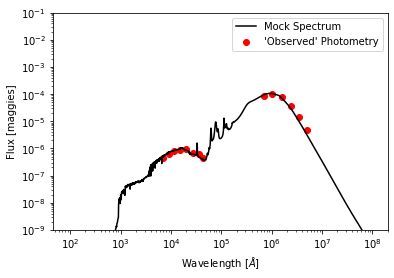

In [65]:
import matplotlib.pyplot as plt
plt.loglog(obs['spec_wave'], obs['true_spec'], color='black', label='Mock Spectrum')
plt.scatter([x.wave_mean for x in obs['filters']], obs['maggies'], color='red', label="'Observed' Photometry")
plt.ylim([1e-9, 1e-1])
plt.ylabel('Flux [maggies]')
plt.xlabel('Wavelength [$\AA$]')
plt.legend()
plt.show()

Now, time to fit our data with our model. To do this, we will call prospector's 'fit_model' function, which is a wrapper on dynesty's dynamic nested sampler. 

In [66]:
#First, set some runtime parameters. These define important parameters for dynesty like how many live points (akin)
#to emcee's walkers, and the stopping condition dlogz. We'll mostly leave these alone for now
run_params = {'output_pickles': False, #our output will be in hdf5 format
              # dynesty Fitter parameters                                                                                                                                                                                                                                                              
              'nested_bound': 'multi',                                                                                                                                                                                                                                        
              'nested_sample': 'auto',                                                                                                                                                                                                                               
              'nested_nlive_init': 400,
              'nested_nlive_batch': 200,
              'nested_bootstrap': 0,
              'nested_dlogz_init': 0.05,
              'nested_weight_kwargs': {"pfrac": 1.0},
              }
#for later use when we compile our results
run_params["sps_libraries"] = sps.ssp.libraries

In [67]:
obs = build_obs()
mod = build_model()
sps = build_sps()

Before running this, I'll note that Propsector is a bit notorious for having long run times. For this relatively simple fit of one SED, it took roughly 20 minutes to stop. For models with more complexity, the run time will increase.

For the sake of your time, I've already run the fit and we can see the results of the output file -- this file is also available in the repo and you can skip down to where we look at the results

In [68]:
from prospect.io import write_results as writer
from prospect.fitting import fit_model

out_file = '/home/s.lower/scripts/jupyter_analysis_notebooks/prospector_tutorial/mock_example.h5'
#output = fit_model(obs, mod, sps, **run_params)

iter: 5226 | batch: 0 | nc: 1 | ncall: 34164 | eff(%): 15.297 | logz: 170.365 +/-  0.189 | dlogz:  0.000 >  0.050       


done dynesty (initial) in 841.747043132782s


iter: 5968 | batch: 1 | nc: 2 | ncall: 38218 | eff(%): 15.486 | loglstar: 176.165 < 179.305 < 177.971 | logz: 170.365 +/-  0.189 | stop:  1.043     

done dynesty (dynamic) in 61.38291788101196s


In [70]:
writer.write_hdf5(out_file, run_params, mod, obs,
              output["sampling"][0], output["optimization"][0],
              tsample=output["sampling"][1],
              toptimize=output["optimization"][1])

/home/s.lower/anaconda3/lib/python3.6/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/home/s.lower/anaconda3/lib/python3.6/site-packages/prospect/io/write_results.py:278: RuntimeWarning: Could not JSON serialize run_params, pickled instead
  RuntimeWarning)
/home/s.lower/anaconda3/lib/python3.6/site-packages/prospect/io/write_results.py:278: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  RuntimeWarning)


Let's visualize our results!

In [71]:
from prospect.io import read_results as pread
results = pread.results_from(out_file)

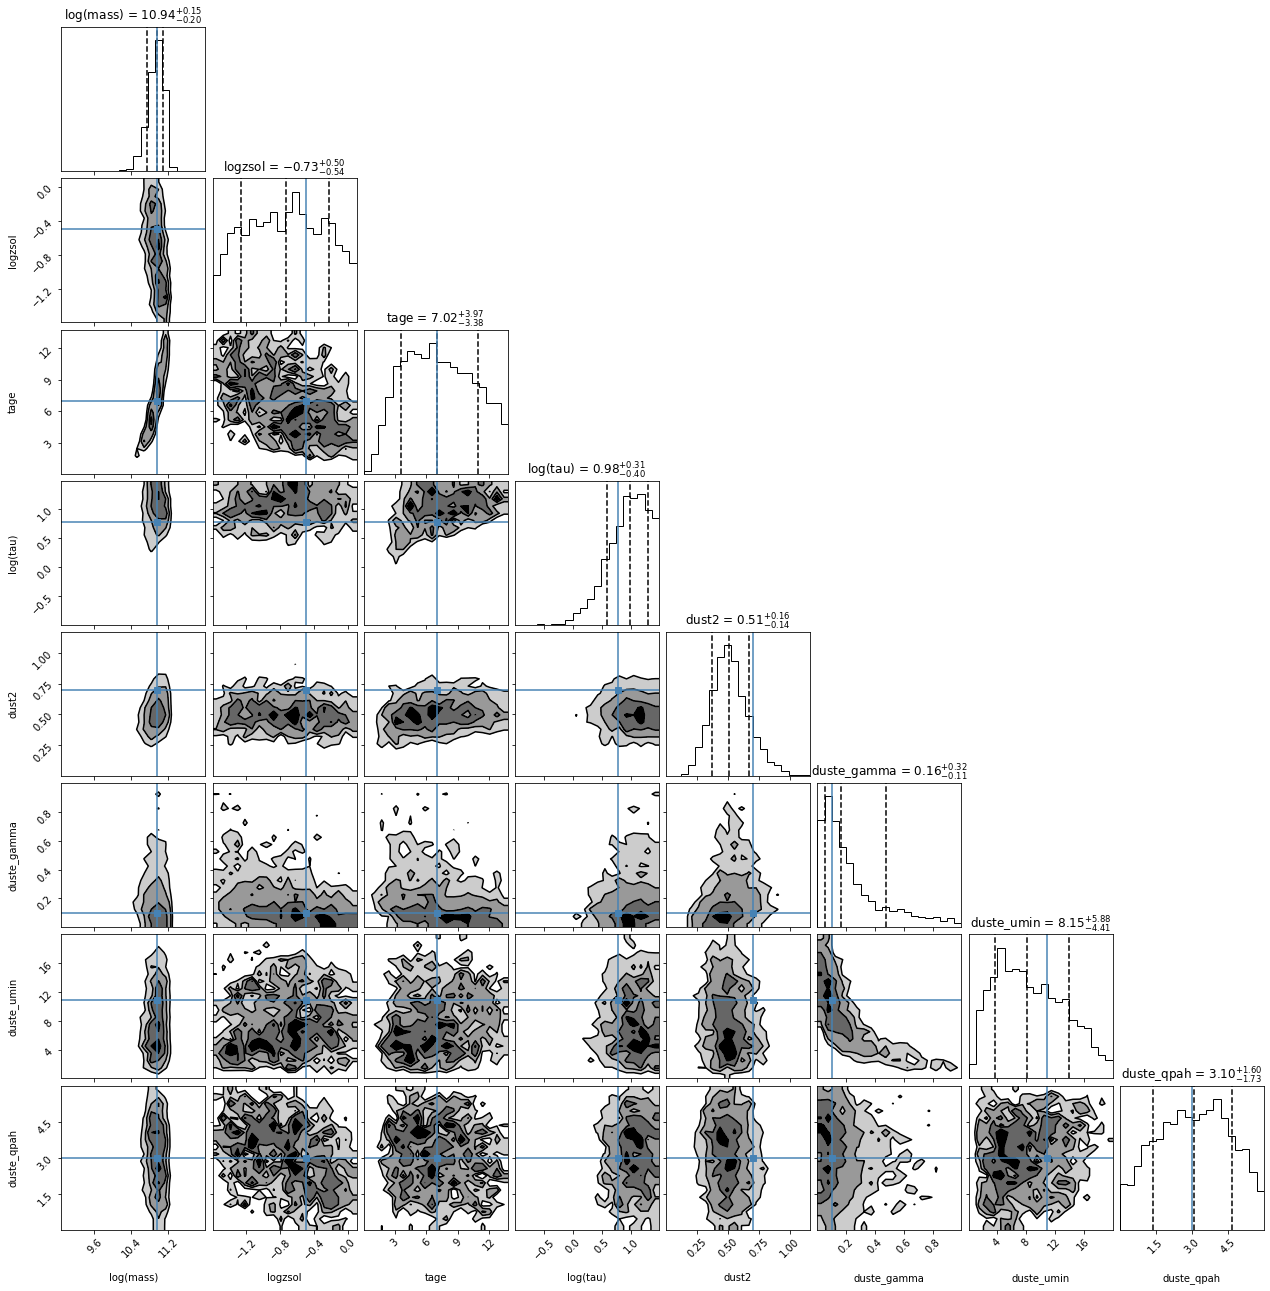

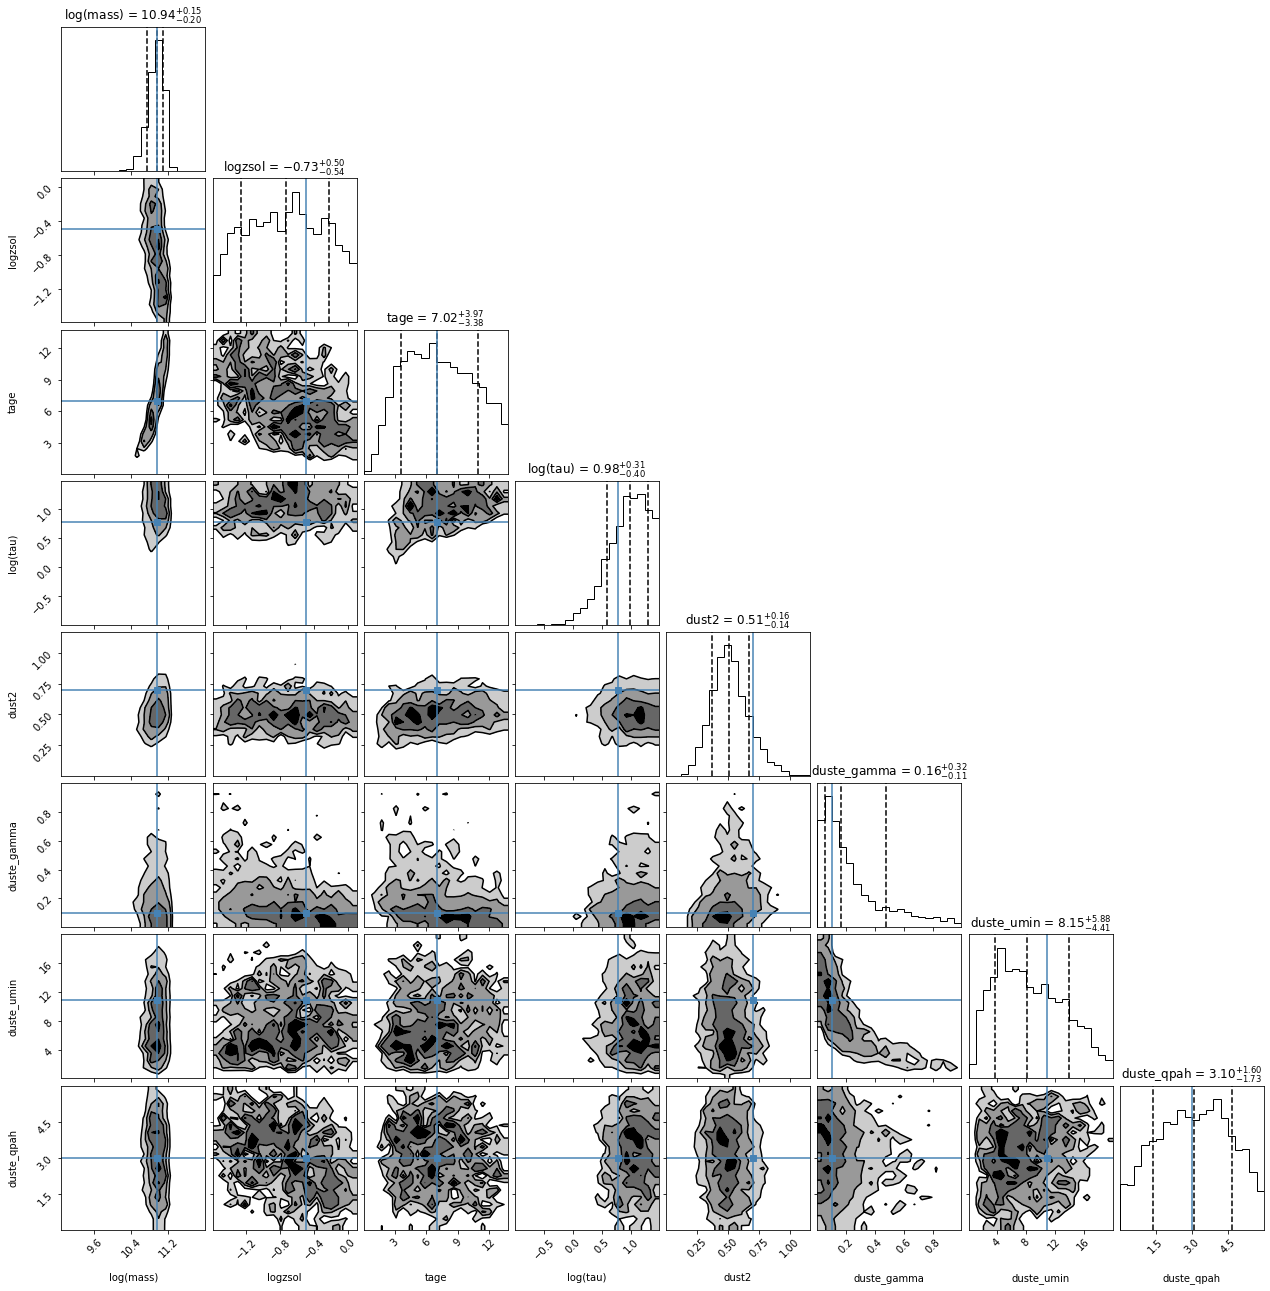

In [72]:
#First, let's take a look at the corner plot of our free parameters

pread.subcorner(results[0], truths=results[1]['true_values'])

This is a corner plot, which is super useful to visualize the results of an MCMC fit. The histograms on the outside are called marginalized posterior distibutions - they show the posterior for a single model parameter independent of the other parameters. The inner 2D histograms show the 2D posterior distributions - these map the correlations / degeneracies between any two model parameters. 

Right off the bat, we can see that our stellar mass is pretty well constrained as well as the timescale of star formation (tau) and the fraction of warm dust. Other parameters like stellar metallicity and the age of the galaxy are less well constrained (by constrained, I mean the relative size of the posterior distributions, our median values are almost spot on for every parameter). 

Let's take a closer look at the posterior distribution for the stellar mass:

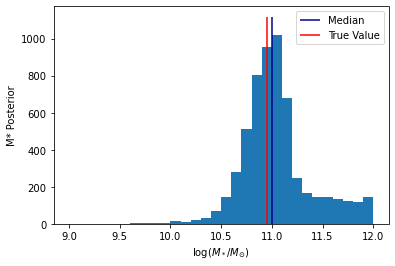

In [81]:
model_thetas = mod.theta_labels()
stellar_mass = results[0]['chain'][:,model_thetas.index('mass')] 
#the 'chain' arrays in our results refer to the samples drawn from the parameter prior distributions.
#we just pull out the stellar mass drawn from the prior for each iteration

n = plt.hist(np.log10(stellar_mass), range=(9, 12), bins=30)
plt.vlines(np.median(np.log10(stellar_mass)), ymin=0, ymax=np.max(n[0])+100, color='darkblue', label='Median')
plt.vlines(np.log10(results[1]['true_values'][model_thetas.index('mass')]), ymin=0, ymax=np.max(n[0])+100, color='red', label='True Value')
plt.ylabel('M* Posterior')
plt.xlabel('$\log(M_* / M_{\odot})$')
plt.legend()

This posterior represents the area of prior space convolved with the likelihood that dynesty sampled, clearly showing a maximum likelihood peaking at ~1e11, which is extremely close to the true value 

We can also look at the SEDs generated by the model fits

In [84]:
from tqdm.auto import tqdm
seds_spec = []
seds_mag = []
#we'll use the mean_model() function to generate the model photometry given each set of model parameters from the posteriors
for i in tqdm(range(len(results[0]['chain']))):
    thetas = results[0]['chain'][i]
    spec, mags, mass_frac = mod.mean_model(thetas,sps=sps,obs=obs)
    seds_spec.append(spec)
    seds_mag.append(mags)

  0%|          | 0/5768 [00:00<?, ?it/s]

In [86]:
from corner import quantile
sed_dist = []
for i in range(len(sps.wavelengths)):
    sed_dist.append(quantile([item[i] for item in seds_spec], [0.1, 0.5, 0.9]))

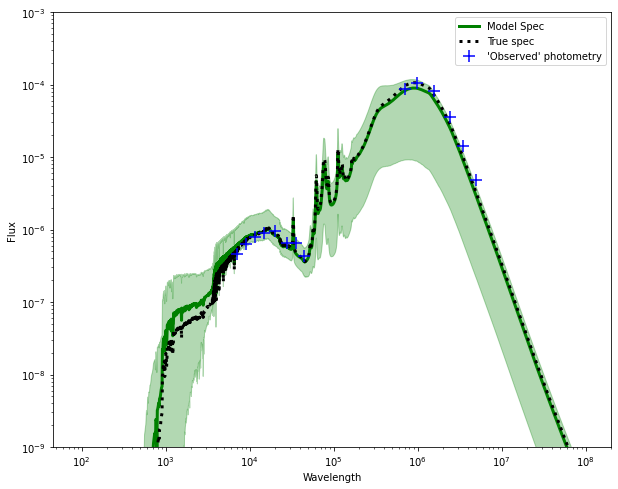

In [101]:
plt.figure(figsize=(10, 8))

plt.loglog(sps.wavelengths, [item[1] for item in sed_dist], color='green', lw=3, label='Model Spec')
plt.fill_between(sps.wavelengths, [item[0] for item in sed_dist], [item[2] for item in sed_dist], color='green', alpha=0.3)

plt.plot(sps.wavelengths, obs['true_spec'], color='black', ls=':', lw=3, label='True spec')
plt.scatter([x.wave_mean for x in obs['filters']], obs['maggies'], color='blue', marker='+', s=150, zorder=10, label="'Observed' photometry")
plt.ylim([1e-9, 1e-3])
plt.ylabel('Flux')
plt.xlabel('Wavelength')
plt.legend()

Here, the distribution of inferred SEDs is shown in green. The solid green line is the median of the distribution while the shaded region are the 10-90th percentiles.

------------------------------------ Part 2: Fitting a 'realistic' SED ---------------------------------------------

Now for a demo that's a little more closer to reality. Still mock SEDs, but from a cosmological simulation. This means our true star formation history and dust properties will be much more complicated than the analytical models we used to generate the mock photometry above, mirroring the real Universe, which means we'll really be testing the ability of our SED fitting tools.

In [7]:
import pandas as pd
from sedpy.observate import load_filters
import matplotlib.pyplot as plt

data = pd.read_csv('example_phot_SED.csv')
spec = pd.read_csv('example_spec_SED.csv')
filters = load_filters(data['filter_name'])

(1000.0, 10000000.0)

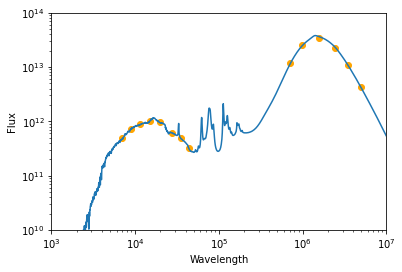

In [8]:
plt.loglog(spec['wavelength'], spec['flux_spec'])
plt.scatter(data['filter_lambda'], data['flux_mag'], color='orange')
plt.ylabel('Flux')
plt.xlabel('Wavelength')
plt.ylim([1e10, 1e14])
plt.xlim([1e3, 1e7])

#SED for galaxy 150, at redshift 0

In [9]:
#First, let's get our data in order
def build_obs_2(**kwargs):
    
    #load up the photometry from a Simba galaxy 
    data = pd.read_csv('example_phot_SED.csv') #same filters as before
    
    phot = data['flux_mag'] / 3631. #convert from Jansky to maggies
    phot_uncertainty = phot * 0.03 #for a real galaxy, each photometry measurement would of course have 
    # its own uncertainty. but since this is still 'fake' data, we just set an arbitrary uncertainty
    # of SNR = 30
    filters = load_filters(data['filter_name'])
    obs = {}
    obs['filters'] = filters
    obs['maggies'] = phot
    obs['maggies_unc'] = phot_uncertainty #flux uncertainties, just proportional to flux. won't be true for real data!
    obs['phot_mask'] = np.isfinite(phot)
    #even though we do have 'spectra' (not really spectra in the observer sense), we won't be using it in our fits
    obs['wavelength'] = None
    obs['spectrum'] = None
    return obs

In [10]:
from prospect.models import priors, transforms #helper functions for specifying priors
from prospect.models import sedmodel
def build_model_2(**kwargs):
    
    """
    Function to build model components for SFH and dust. 
    The model params are defined by their name, whether they are a free parameter
    their initial value, and their prior distribution if they are variable. The model 
    params are then fed to the prospector SedModel class
    
    All parameters except 'mass' correspond to fsps model parameters, the definitions of which you can find here:
    https://dfm.io/python-fsps/current/stellarpop_api/
    
    This time, we will be using something called a non-parametric star formation history model. You don't
    _really_ need to understand this in detail, but if you want to read up on it here's a few places to start:
    https://arxiv.org/abs/1811.03637
    https://arxiv.org/abs/2006.03599
    
    The 
    
    """
    
    model_params = []
    #redshift of galaxy. Working with simulated data is weird in that our galaxy is at redshift 0, specifically
    #our observed SED is at a luminosity distance of 10 pc --> completely unphysical in the real Universe but 
    #ultimately doesn't matter because we can just fix that value in our model
    model_params.append({'name': "zred", "N": 1, "isfree": False,"init": 0.1, 'prior': None})
    model_params.append({'name': "lumdist", "N": 1, "isfree": False,"init": 1e-5, 'units': 'Mpc'})
    #IMF model which will be used by the simple stellar population model
    model_params.append({'name': 'imf_type', 'N': 1,'isfree': False,'init': 2, 'prior': None})
    #stellar mass
    model_params.append({'name': 'logmass', 'N': 1,'isfree': True, 'init': 10.0,'prior': priors.TopHat(mini=8, maxi=12)})
    #stellar metallicity
    model_params.append({'name': 'logzsol', 'N': 1,'isfree': True,'init': -0.5,'prior': priors.TopHat(mini=-1.6, maxi=0.1)})
    #non parametric SFH model
    #essentially, this model is comprised of a handful of piece-wise bins of constant SFR. the prior on the 
    # normalization (shape) of the SFH is a Dirichlet distribution 
    model_params.append({'name': "sfh", "N": 1, "isfree": False, "init": 3})
    #here, mass =/= the total stellar mass, but rather the stellar mass in each bin of constant SFR
    # these parameters depend on the z_fraction parameters through a conversion
    model_params.append({'name': "mass", 'N': 3, 'isfree': False, 'init': 1., 'depends_on':zfrac_to_masses_log})
    model_params.append({'name': "agebins", 'N': 1, 'isfree': False,'init': []})
    # this proxy parameter is what's actually varied in the SFH model
    model_params.append({'name': "z_fraction", "N": 2, 'isfree': True, 'init': [0, 0],'prior': priors.Beta(alpha=1.0, beta=1.0, mini=0.0, maxi=1.0)})
    #dust attenuation model, from Kriek & Conroy 2013, this time we allow a variable attenuation curve slope
    model_params.append({'name': 'dust_type', 'N': 1,'isfree': False,'init': 4,'prior': None})
    #the attenuation (in magnitudes) in the V-band
    model_params.append({'name': 'dust2', 'N': 1,'isfree': True, 'init': 0.1,'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=0.0, sigma=0.3)})
    #the attenuation (in magnitudes) in the V-band
    model_params.append({'name': 'dust_index', 'N': 1,'isfree': True, 'init': -0.3,'prior': priors.TopHat(mini=-1.6, maxi=0.3)})
    #dust emission model -- only 1 choice, from Draine & Li 2007
    model_params.append({'name': 'add_dust_emission', 'N': 1,'isfree': False,'init': 1,'prior': None})
    #mass fraction of warm dust
    model_params.append({'name': 'duste_gamma', 'N': 1,'isfree': True,'init': 0.01,'prior': priors.TopHat(mini=0.0, maxi=1.0)})
    #minimum radiation field
    model_params.append({'name': 'duste_umin', 'N': 1,'isfree': True,'init': 1.0,'prior': priors.TopHat(mini=0.1, maxi=20.0)})
    #mass fraction of dust in PAHs
    model_params.append({'name': 'duste_qpah', 'N': 1,'isfree': False,'init': 5.86,'prior': priors.TopHat(mini=0.0, maxi=6.0)})
    
    #now modify our SFH model to our specifications
    n = [p['name'] for p in model_params]
    tuniv = 14.0
    nbins=6 #6 bins of constant SFR
    tbinmax = (tuniv * 0.85) * 1e9
    lim1, lim2 = 8.0, 8.52 #100 Myr and 330 Myr   
    #so our choice of both # and placement of timebins are ~arbitrary, but i space them out evenly in log(time) space
    agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
    agebins = np.array([agelims[:-1], agelims[1:]])
    ncomp = nbins
    alpha_sfh = 0.7  # desired Dirichlet concentration                                                                                                       \                                                                                                                                                   
    alpha = np.repeat(alpha_sfh,nbins-1)
    tilde_alpha = np.array([alpha[i-1:].sum() for i in range(1,ncomp)])
    zinit = np.array([(i-1)/float(i) for i in range(ncomp, 1, -1)])
    zprior = priors.Beta(alpha=tilde_alpha, beta=alpha, mini=0.0, maxi=1.0)
    model_params[n.index('mass')]['N'] = ncomp
    model_params[n.index('agebins')]['N'] = ncomp
    model_params[n.index('agebins')]['init'] = agebins.T
    model_params[n.index('z_fraction')]['N'] = len(zinit)
    model_params[n.index('z_fraction')]['init'] = zinit
    model_params[n.index('z_fraction')]['prior'] = zprior
    
    model = sedmodel.SedModel(model_params)
    return model

def zfrac_to_masses_log(logmass=None, z_fraction=None, agebins=None, **extras):
    sfr_fraction = np.zeros(len(z_fraction) + 1)
    sfr_fraction[0] = 1.0 - z_fraction[0]
    for i in range(1, len(z_fraction)):
        sfr_fraction[i] = np.prod(z_fraction[:i]) * (1.0 - z_fraction[i])
    sfr_fraction[-1] = 1 - np.sum(sfr_fraction[:-1])
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    mass_fraction = sfr_fraction * np.array(time_per_bin)
    mass_fraction /= mass_fraction.sum()

    masses = 10**logmass * mass_fraction
    return masses

In [11]:
from prospect.sources import FastStepBasis
def build_sps_2(**kwargs):
    """
    This is our stellar population model which generates the spectra for stars of a given age and mass. 
    Because we are using a non parametric SFH model, we do have to use a different SPS model than before 
    """
    sps = FastStepBasis(zcontinuous=1)
    return sps

In [12]:
mod_2 = build_model_2()
obs_2 = build_obs_2()
sps_2 = build_sps_2()

In [30]:
# Now to run prospector on our Simba galaxy SED
run_params = {'output_pickles': False, #our output will be in hdf5 format
              # dynesty Fitter parameters                                                                                                                                                                                                                                                              
              'nested_bound': 'multi',                                                                                                                                                                                                                                        
              'nested_sample': 'auto',                                                                                                                                                                                                                               
              'nested_nlive_init': 400,
              'nested_nlive_batch': 200,
              'nested_bootstrap': 0,
              'nested_dlogz_init': 0.05,
              'nested_weight_kwargs': {"pfrac": 1.0},
              }
run_params["sps_libraries"] = sps_2.ssp.libraries

Again, prospector takes a decent amount of time to run. This is especially true since our model has increased in the number of parameters and complexity. 

Like before, you can skip the actually running part and just load up the results. 

In [32]:
from prospect.io import write_results as writer
from prospect.fitting import fit_model
from corner import quantile

out_file = '/home/s.lower/scripts/jupyter_analysis_notebooks/prospector_tutorial/simba_example.h5'
#output = fit_model(obs_2, mod_2, sps_2, **run_params)
#writer.write_hdf5(out_file, run_params, mod_2, obs_2,
#              output["sampling"][0], output["optimization"][0],
#              tsample=output["sampling"][1],
#              toptimize=output["optimization"][1])

In [2]:
from prospect.io import read_results as pread
results = pread.results_from(out_file)

In [3]:
#Galaxy 150 properties from the simulation:
true_log_stellar_mass = 10.43
true_logzsol = -0.29
true_SFR = 1.17
true_dust_index = -0.56
true_dust2 = 0.48

truths = [true_log_stellar_mass, true_logzsol, true_SFR, true_dust_index, true_dust2]

Before we plot some results, we need to do some work to convert our model parameters to useful quantities. Specifically, we want to take our non parametric model and extract our SFR from that. To do this, we'll use some helper functions from Prospector. 

In [14]:
def get_sfr100(res, mod):
    agebins = mod.params['agebins']
    thetas = mod.theta_labels()                                                                                                                                           
    agebins_yrs = 10**agebins.T
    dt = agebins_yrs[1, :] - agebins_yrs[0, :]

    zfrac_idx = [i for i, s in enumerate(thetas) if 'z_fraction' in s]
    zfrac_chain = res['chain'][:,zfrac_idx[0]:zfrac_idx[-1]+1]
    try:
        total_mass_chain = res['chain'][:,thetas.index('massmet_1')]
    except:
        total_mass_chain = res['chain'][:,thetas.index('logmass')]
    sfr_chain = []
    for i in range(len(zfrac_chain)):
        #this is the important part of this function -- it takes the proxy model parameters we sampled
        # and transforms them into the masses formed in each timebin
        # from there, we just divide these masses by the time in each bin to get the SFR in each bin
        masses_chain = transforms.zfrac_to_masses(10**total_mass_chain[i], zfrac_chain[i], agebins)
        sfr = masses_chain / dt                                                                                                                                  
        sfr_chain.append(sfr[0])                                                                                                                                                
    return sfr_chain

In [15]:
model_sfr = get_sfr100(results[0], mod_2)

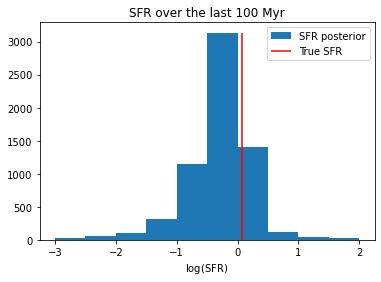

In [16]:
#now plot model SFR histogram

n, _, _ = plt.hist(np.log10(model_sfr), range=(-3, 2), label='SFR posterior')
plt.vlines(np.log10(true_SFR), 0, np.max(n), color='red', label='True SFR')
plt.title('SFR over the last 100 Myr')
plt.xlabel('$\log(\mathrm{SFR})$')
plt.legend()

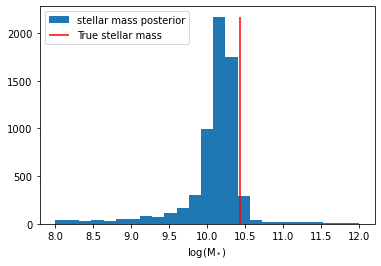

In [20]:
#and stellar mass
stellar_mass_posterior = results[0]['chain'][:,mod_2.theta_labels().index('logmass')]
n, _, _ = plt.hist(stellar_mass_posterior, range=(8, 12),bins=25, label='stellar mass posterior')
plt.vlines(true_log_stellar_mass, 0, np.max(n), color='red', label='True stellar mass')
plt.xlabel('$\log(\mathrm{M}_*)$')
plt.legend()

In [51]:
#and finally, the inferred full SFH (not just the last 100Myr)
def get_sfh(res, mod):
    agebins = mod.params['agebins']
    thetas = mod.theta_labels()                                                                                                                                           
    agebins_yrs = 10**agebins.T
    bin_edges = np.unique(agebins_yrs)
    dt = agebins_yrs[1, :] - agebins_yrs[0, :]
    epsilon = 1e-4 #fudge factor used to define the fraction time separation of adjacent points at the bin edges
    t = np.concatenate((bin_edges * (1.-epsilon), bin_edges * (1+epsilon)))
    t.sort()
    t = t[1:-1]
    zfrac_idx = [i for i, s in enumerate(thetas) if 'z_fraction' in s]
    zfrac_chain = res['chain'][:,zfrac_idx[0]:zfrac_idx[-1]+1]
    try:
        total_mass_chain = res['chain'][:,thetas.index('massmet_1')]
    except:
        total_mass_chain = res['chain'][:,thetas.index('logmass')]
    sfr_chain = []
    for i in range(len(zfrac_chain)):
        masses_chain = transforms.zfrac_to_masses(10**total_mass_chain[i], zfrac_chain[i], agebins)
        sfr = masses_chain / dt    
        sfrout = np.zeros_like(t)                                                                                                                            
        sfrout[::2] = sfr                                                                                                                                    
        sfrout[1::2] = sfr
        sfr_chain.append(sfrout)                                                                                                                                                
    return (14. - t/1e9), sfr_chain 



In [52]:
t, sfh = get_sfh(results[0], mod_2)

In [53]:
sfh_50, sfh_16, sfh_84 = [], [], []
for time in range(len(t)):
    sfr_quan = quantile([item[time] for item in sfh], [0.16, 0.5, 0.84])
    sfh_50.append(sfr_quan[1])
    sfh_16.append(sfr_quan[0])
    sfh_84.append(sfr_quan[2])

In [72]:
true_sfh_file = np.load('galaxy_150_sfh.npz')
true_sfh = np.array(true_sfh_file['sfr'])[::-1]
true_time = np.arange(0, 14.2, 0.1) #this is very bad practice on my part. always include your time axis in the data file !!

Text(0.5, 0, 'Age of Universe [Gyr]')

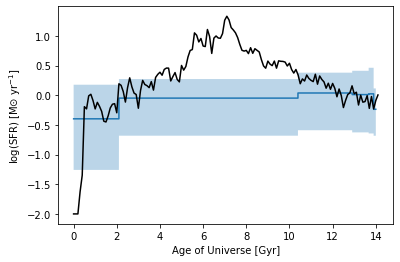

In [73]:
plt.plot(t, np.log10(sfh_50)) #this is the median inferred SFH
plt.fill_between(t, y1=np.log10(sfh_16), y2=np.log10(sfh_84), alpha=0.3, zorder=0) #this covers the 1sigma width
plt.plot(true_time, np.log10(true_sfh), color='black')
plt.ylabel('$\log(\mathrm{SFR})$ [M${\odot}$ yr$^{-1}$]')
plt.xlabel('Age of Universe [Gyr]')

So you can see that propsector missed out on that huge increase in star formation around 7 Gyr, mostly because our time resolution for the SFH model isn't small enough. Increasing our # of time bins might help get a better SFH estimate. 

But in any case, that ends our intro to SED modeling tutorial! In the folder for this tutorial, I've included two example scripts: one that I use to run prospector to fit the Simba SEDs (run_prosp.py) and one to process the results from those fits (get_prosp_quantities.py). Of course, you'll need to edit them to your needs, but they at least provide a foundation. 

## appendix: dealing with units :(

In [145]:
#generate quick FSPS spectra
import fsps
sp = fsps.StellarPopulation(zcontinuous=1, sfh=0, add_dust_emission=True, dust2=0.5)

In [146]:
wav, lum = sp.get_spectrum(tage=5) #wav in Angstrom, lum in Lsun / Hz

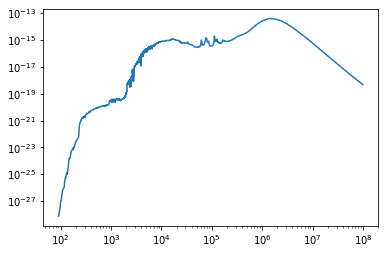

In [147]:
plt.loglog(wav, lum)

FSPS spits out SED units in solar luminosities / Hz for some reason. Not only is this a bit unintuitive, but for use with prospector, which expects SEDs in units of maggies, it's non-trivial to convert. Here's how I've done it:

In [148]:
import astropy.units as u
import astropy.constants as constants

lum = lum * u.Lsun / u.Hz

In [149]:
lum

<Quantity [7.87638705e-29, 1.54538861e-28, 2.50674857e-28, ...,
           5.02541280e-19, 4.89240598e-19, 4.76620348e-19] solLum / Hz>

In [150]:
luminosity_distance = 10 * u.pc #this is obviously arbitrary, meaning our flux will be scaled to whatever distance we put here
#for prospector use, make sure we match 'lumdist' in our model to whatever distance we decide here

lum_cgs = lum.cgs
flux_jansky = (lum_cgs / (4 * np.pi * (luminosity_distance)**2)).to(u.Jy)

In [151]:
flux_jansky

<Quantity [2.51992737e-12, 4.94423018e-12, 8.01995165e-12, ...,
           1.60780256e-02, 1.56524910e-02, 1.52487258e-02] Jy>

In [152]:
#finally, maggies are just a linear scaling of jansky
flux_maggies = flux_jansky.value / 3631.

In [153]:
flux_maggies

array([6.94003683e-16, 1.36167177e-15, 2.20874460e-15, ...,
       4.42798833e-06, 4.31079345e-06, 4.19959399e-06])

Text(0.5, 0, 'Wavelength [$\\AA$]')

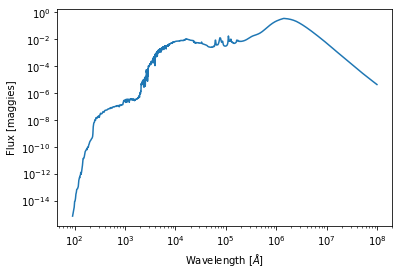

In [154]:
plt.loglog(wav, flux_maggies)
plt.ylabel('Flux [maggies]')
plt.xlabel('Wavelength [$\AA$]')